# 4. 프로젝트: U-Net 성능 개선해 보기

* U-Net의 인코더 모델을 VGG, ResNet 등 기존의 pretrained model을 활용하는 것은 가능한지, 성능 개선 효과가 있을지 확인
* 사전 학습된 모델(Pretrained model)은 ImageNet 데이터를 이용해 pretrain된 것이 대부분
* transfer learning(전이 학습)이 훨씬 효과적인 것으로 알려져 있지만 의료 영상 도메인에도 동일하게 효과적일까요?
* 사전 학습된 모델을 이용하기

### 라이브러리 버전 확인

In [37]:
import tensorflow
import sklearn
import numpy

print(tensorflow.__version__)
print(sklearn.__version__)
print(numpy.__version__)

2.6.0
1.0
1.21.4


## STEP 1 : 데이터셋 구성

* Giana 데이터셋을 그대로 활용
* augmentation을 위한 파이프라인 구성
* tf.data.Dataset을 이용한 배치처리를 통해 학습/테스트 데이터셋을 구성

### 1-1. 데이터 수집 및 Visualization

* 위내시경 용종 데이터셋을 전처리하고 시각화하는 과정을 먼저 진행
* 라이브러리를 로딩

In [38]:
# 필요 라이브러리 로딩
from __future__ import absolute_import, division
from __future__ import print_function, unicode_literals

import os
import time
import shutil
import functools

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.image as mpimg
import pandas as pd
from PIL import Image
from IPython.display import clear_output

import tensorflow as tf
import tensorflow_addons as tfa
print(tf.__version__)

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models

2.6.0


####  데이터 준비

* 데이터 세트를 학습 데이터와 테스트 데이터로 분할

In [39]:
# 데이터셋을 학습용과 테스트용으로 분리
# train, train_labels 디렉토리에 분리, 쌍을 이루는 이미지와 라벨의 파일명은 동일
# 사이킷런의 train_test_split을 이용해서 학습(train) 데이터와 테스트(test) 데이터를 분리

DATASET_PATH = os.path.join(os.getenv('HOME'), 'aiffel', 'medical')

img_dir = os.path.join(DATASET_PATH, "train")
label_dir = os.path.join(DATASET_PATH, "train_labels")

x_train_filenames = [os.path.join(img_dir, filename) for filename in os.listdir(img_dir)]
x_train_filenames.sort()
y_train_filenames = [os.path.join(label_dir, filename) for filename in os.listdir(label_dir)]
y_train_filenames.sort()

x_train_filenames, x_test_filenames, y_train_filenames, y_test_filenames = \
                    train_test_split(x_train_filenames, y_train_filenames, test_size=0.2)

num_train_examples = len(x_train_filenames)
num_test_examples = len(x_test_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples: {}".format(num_test_examples))

Number of training examples: 240
Number of test examples: 60


#### 시각화(Visualization)

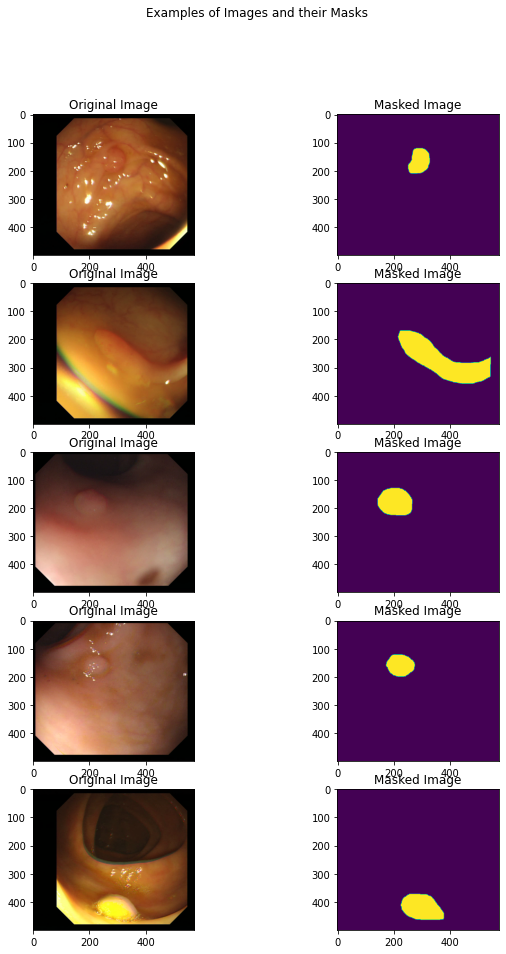

In [40]:
# 데이터 셋에서 이미지 샘플을 5개 확인
display_num = 5

r_choices = np.random.choice(num_train_examples, display_num) #훈련데이타:num_train_examples 240,5

plt.figure(figsize=(10, 15))
for i in range(0, display_num * 2, 2):
    img_num = r_choices[i // 2]
    #print('i:',i)
    #print('img_num:',img_num)
    x_pathname = x_train_filenames[img_num] #학습데이타-문제
    y_pathname = y_train_filenames[img_num] #학습데이타-답지

    plt.subplot(display_num, 2, i + 1)
    plt.imshow(Image.open(x_pathname))  #학습데이타-문제
    plt.title("Original Image")

    example_labels = Image.open(y_pathname) #학습데이타-답지
    label_vals = np.unique(example_labels)  

    plt.subplot(display_num, 2, i + 2)
    plt.imshow(example_labels)
    plt.title("Masked Image")
    
plt.suptitle("Examples of Images and their Masks")
plt.show()

* 클래스 값이 아니라, 입력이미지와 동일한 X-Y 사이즈를 가지고 용종 부위만 표시된 1채널짜리 이미지
* Semantic Segmentation

### 1-2. 데이터 파이프라인 및 전처리(Data pipeline and Preprocessing)

* 하이퍼파라메터 설정

In [41]:
# 하이퍼파라미터를 미리 셋팅

image_size = 256
img_shape = (image_size, image_size, 3)
batch_size = 8
max_epochs = 10

#### 각 경로명 처리(Processing each pathname)

* 이미지 데이터를 로드하는 함수를 구현
  - byte 형태로 데이터를 로드하고, bmp로 디코딩
  - 디코딩이 완료된 image를 scale과 size를 조절

In [42]:
# 경로명 처리
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    img = tf.image.decode_bmp(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    label_img = tf.image.decode_bmp(label_img_str, channels=3) #byte 형태로 데이터를 로드하고, bmp로 디코딩
    label_img = tf.image.rgb_to_grayscale(label_img)

    resize = [image_size, image_size]
    img = tf.image.resize(img, resize)  #디코딩이 완료된 image size를 조절
    label_img = tf.image.resize(label_img, resize) #디코딩이 완료된 label_img 를 scale과 size를 조절

    scale = 1 / 255.
    img = tf.cast(img, dtype=tf.float32) * scale
    label_img = tf.cast(label_img, dtype=tf.float32) * scale

    return img, label_img

#### 데이터 증강 
 1) 이미지 이동 (Data augmentation - Shifting the image)
   - 로드한 이미지를 기반으로 이미지의 위치를 적절히 이동(shift)시키는 함수
   - 입력이미지와 라벨의 쌍을 동일하게 shift

In [43]:
#이미지 이동
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    # 수평 또는 수직 이동을 수행
    if width_shift_range or height_shift_range:
        if width_shift_range: #수평이동
                width_shift_range = tf.random.uniform([],
                                                  -width_shift_range * img_shape[1],
                                                  width_shift_range * img_shape[1])
        if height_shift_range: #수직이동
                height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        output_img = tfa.image.translate(output_img,
                                         [width_shift_range, height_shift_range])
        label_img = tfa.image.translate(label_img,
                                        [width_shift_range, height_shift_range])
    return output_img, label_img

2) 무작위로 이미지 뒤집기(Data augmentation - Flipping the image randomly)
  - 로드한 이미지를 기반으로 이미지를 flip하는 함수, 50%의 확률로 좌우반전만 구현

In [44]:
# 무작위로 이미지 뒤집기
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip: #좌우반전만
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                                lambda: (tr_img, label_img))
    return tr_img, label_img

3) 데이터 증강 구현

* Augmentation용 함수를 이용해 Data augmentation에 사용하는 _augment() 함수를 구성
* resize, hue_delta가 적용

In [45]:
#데이터 증강 구현
def _augment(img,
             label_img,
             resize=None,  # 이미지 크기를 일부 크기로 조정, 예제)[256, 256]
             scale=1,  # 스케일 이미지, 예제) 1 / 255.
             hue_delta=0.,  # 무작위 요소로 RGB 이미지의 색조 조정
             horizontal_flip=True,  # 무작위 왼쪽 오른쪽 뒤집기
             width_shift_range=0.05,  # 이미지를 무작위로 수평으로 번역
             height_shift_range=0.05):  # 이미지를 무작위로 수직으로 번역
    if resize is not None: #resize 값이 존재시 처리
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)
  
    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)
  
    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, dtype=tf.float32) * scale
    img = tf.cast(img, dtype=tf.float32) * scale
    return img, label_img

### 1-3. 학습 및 테스트 데이터 세트 설정

* tf.data.Dataset을 이용하여 데이터셋 배치구성, 셔플링 등을 구현
* augmentation도 함께 적용
* 단, Train dataset에서만 Data augmentation을 진행하게 설정하는 것에 주의 !!!

In [46]:
# 기준 데이터세트 가져오기
def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=4,
                         batch_size=batch_size,
                         is_train=True):
    num_x = len(filenames)
    
    # 파일 이름과 라벨로 데이터 세트 만들기
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    
    # 전처리 기능을 데이터 세트의 모든 요소에 매핑하여 다음을 수행
    # 멀티스레딩의 장점
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if is_train:# 학습을 진행할시에만 위에 augment를 진행합니다.
        #preproc_fn.keywords가 None이 아니고 preproc_fn.keywords에 '크기 조정'이 없는 경우:
        #  batch_size == 1, 일괄 처리 이미지의 크기는 동일해야 함
        dataset = dataset.map(preproc_fn, num_parallel_calls=threads)
        dataset = dataset.shuffle(num_x * 10)

    dataset = dataset.batch(batch_size)
    return dataset


#학습 및 테스트 데이터 세트 설정하기
train_dataset = get_baseline_dataset(x_train_filenames, # 학습 데이터
                                     y_train_filenames) # 학습-정답 데이터
train_dataset = train_dataset.repeat()

test_dataset = get_baseline_dataset(x_test_filenames,  #테스트 데이터
                                    y_test_filenames,  #테스트-정답 데이터
                                    is_train=False)
train_dataset

<RepeatDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 1)), types: (tf.float32, tf.float32)>

#### 학습데이터 구성 (Plot some train data)

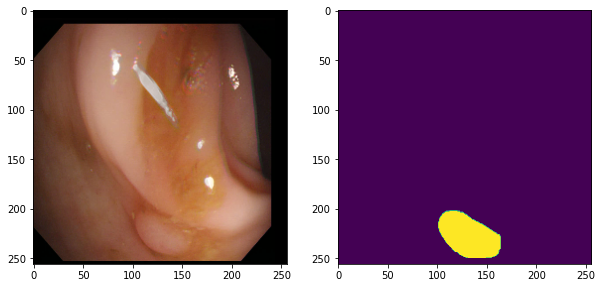

In [47]:
#학습데이터 시각화하기
for images, labels in train_dataset.take(1):
    # 그래프에서 다음 요소를 실행하면 일련의 이미지가 생성
    plt.figure(figsize=(10, 10))
    img = images[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)

    plt.subplot(1, 2, 2)
    plt.imshow(labels[0, :, :, 0])
    plt.show()

## STEP 2 : pretrained model을 활용한 U-Net 모델 구성

* Encoder ->  pretrained 모델로 변경하는 작업진행(VGG16을 활용하기 위한 것)
  -  마음에 드는 다른 모델을 활용하기 위해 다양하게 시도해 보는 것을 권장
* VGG16 모델의 레이어 구성을 확인하기
* U-Net이란 Encoder와 Decoder 사이의 대응되는 레이어간의 skip connection이 특징인 모델
* Encoder를 pretrained model로 바꿔주려면 Encoder로 활용할 모델의 레이어 구성 확인하기

---
* 인코더 : pretrained 모델.VGG16 모델의 레이어 구성
* 디코더 : Decoder 레이어 이용하여 모델구성하여 U-Net 모델구성하기

In [48]:
vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')

layer_outputs = [layer.output for layer in vgg16.layers]
layer_outputs

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_3')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv1')>,
 <KerasTensor: shape=(None, 256, 256, 64) dtype=float32 (created by layer 'block1_conv2')>,
 <KerasTensor: shape=(None, 128, 128, 64) dtype=float32 (created by layer 'block1_pool')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv1')>,
 <KerasTensor: shape=(None, 128, 128, 128) dtype=float32 (created by layer 'block2_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 128) dtype=float32 (created by layer 'block2_pool')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv1')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv2')>,
 <KerasTensor: shape=(None, 64, 64, 256) dtype=float32 (created by layer 'block3_conv3')>,
 <KerasTensor: shape=(None, 32, 32, 256) dtype=float32 (created by layer 'block3_pool')>,


### 2-1. U-Net 아키텍처 (U-Net architecture)

In [49]:
#ConvBlock 에서 이용함
class Conv(tf.keras.Model):
    def __init__(self, num_filters, kernel_size):
        super(Conv, self).__init__()
        self.conv = layers.Conv2D(num_filters, kernel_size, padding='same')
        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=True):
        x = self.conv(inputs)
        x = self.bn(x, training=training)
        x = layers.ReLU()(x)

        return x
    
#
class ConvBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters * 2, 3)

    def call(self, inputs, training=True):
        encoder = self.conv1(inputs, training=training)
        encoder = self.conv2(encoder, training=training)
        
        return encoder
    
#DecoderBlock 에서 이용함
class ConvBlock_R(tf.keras.Model):
    def __init__(self, num_filters):
        super(ConvBlock_R, self).__init__()
        self.conv1 = Conv(num_filters, 3)
        self.conv2 = Conv(num_filters, 3)

    def call(self, inputs, training=True):
        decoder = self.conv1(inputs, training=training)
        decoder = self.conv2(decoder, training=training)
        
        return decoder 
    
    
#디코더블록
class DecoderBlock(tf.keras.Model):
    def __init__(self, num_filters):
        super(DecoderBlock, self).__init__()
        self.convT = layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same')
        self.bn = layers.BatchNormalization()
        self.conv_block_r = ConvBlock_R(num_filters)

    def call(self, input_tensor, concat_tensor, training=True):
        decoder = self.convT(input_tensor)            
        decoder = self.bn(decoder, training=training)
        decoder = layers.ReLU()(decoder)
        decoder = tf.concat([decoder, concat_tensor], axis=-1)
        decoder = self.conv_block_r(decoder, training=training)

        return decoder    

* VGG16의 경우 모델구성이 특히나 U-Net의 그것과 닮았다는 것을 알수있다.
* 모델 구조가 유사하면 결합하여 사용하기에 유리
  - 아래는 VGG16을 Encoder로 활용하여 개선한 새로운 모델 클래스
  - 모델을 구성하기 위해서 내부에서 새로운 모델(vgg16_act)을 생성
* vgg16_act : VGG16의 특정 레이어 출력을 가져와 Decoder와 연결하기 위한 것
  -  UNet 클래스와 비교하면, encoder 레이어가 없어지고 vgg16_act 모델의 출력이 그 역할을 대신하고 있음

In [50]:
class Vgg16UNet(tf.keras.Model):
    def __init__(self):
        super(Vgg16UNet, self).__init__()
        self.vgg16 = tf.keras.applications.VGG16(input_shape=img_shape,
                                         include_top=False,
                                         weights='imagenet')
        layer_outputs = [layer.output for layer in self.vgg16.layers]
        self.vgg16_act = models.Model(inputs=self.vgg16.input, 
                                      outputs=[layer_outputs[2], 
                                               layer_outputs[5], 
                                               layer_outputs[9], 
                                               layer_outputs[13], 
                                               layer_outputs[17]])


        self.center = ConvBlock(1024)

        self.decoder_block4 = DecoderBlock(512)
        self.decoder_block3 = DecoderBlock(256)
        self.decoder_block2 = DecoderBlock(128)
        self.decoder_block1 = DecoderBlock(64)

        self.output_conv = layers.Conv2D(1, 1, activation='sigmoid')

    def call(self, inputs, training=True):

        encoder1, encoder2, encoder3, encoder4, center = self.vgg16_act(inputs) 

        decoder4 = self.decoder_block4(center, encoder4)
        decoder3 = self.decoder_block3(decoder4, encoder3)
        decoder2 = self.decoder_block2(decoder3, encoder2)
        decoder1 = self.decoder_block1(decoder2, encoder1)
        
        outputs = self.output_conv(decoder1)

        return outputs

#### U-Net 모델 생성

In [51]:
#구현한 Class들을 생성해 최종적으로 U-net 모델을 구현
unet_model = Vgg16UNet()

## STEP 3 : 학습과 테스트, 시각화

* 모델을 변경하여 실습과정과 동일하게 학습과 테스트, 시각화를 진행

#### 메트릭과 손실 함수를 정의

In [52]:
# Image Segmentation Task에서 정답을 더 잘 찾아내기위해 새로운 Loss를 추가
def dice_coeff(y_true, y_pred):
    smooth = 1e-10
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(tf.square(y_true_f)) + \
                                            tf.reduce_sum(tf.square(y_pred_f)) + smooth)

    return score

# Dice Loss가 최대화되는 방향으로 구해지도록, 아래와 같이 사용
def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


# 새로운 Loss function을 사용하기위해서 기존에 사용하였던 Binary crossentropy loss와 새로 구현한 Dice loss를 더하는 방식으로 구성
def bce_dice_loss(y_true, y_pred):
    loss = tf.reduce_mean(losses.binary_crossentropy(y_true, y_pred)) + dice_loss(y_true, y_pred)
    return loss

In [53]:
optimizer = tf.keras.optimizers.Adam() # 기본 Learning rate 사용

#### 모델선택

In [55]:
print('select the U-Net model')
model = unet_model
checkpoint_dir = os.path.join(DATASET_PATH,'train_ckpt/unet_model') #우리가 학습시키는 모델명

select the U-Net model


#### 컴파일(Compile)

In [56]:
#U-Net model로 컴파일과정
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[dice_loss])
predictions = model(tf.random.normal([batch_size, image_size, image_size, 3]))
print(predictions.shape)

ResourceExhaustedError: OOM when allocating tensor with shape[8,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:FusedBatchNormV3]

In [23]:
#모델요약 확인 (U-Net model)
model.summary()

Model: "vgg16u_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
model (Functional)           [(None, 256, 256, 64), (N 14714688  
_________________________________________________________________
conv_block (ConvBlock)       multiple                  0 (unused)
_________________________________________________________________
decoder_block (DecoderBlock) multiple                  9444864   
_________________________________________________________________
decoder_block_1 (DecoderBloc multiple                  2952960   
_________________________________________________________________
decoder_block_2 (DecoderBloc multiple                  739200    
_________________________________________________________________
decoder_block_3 (DecoderBloc multiple                  1

In [27]:
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# 모델 학습간 특정 feature를 모니터링하다 기준점을 넘으면 모델 파라미터를 저장
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=0)

OSError: [Errno 30] Read-only file system: '/aiffel/aiffel/medical/unet_ckpt/unet_model'

In [25]:
# 인쇄 기능 정의
def print_images():
    for test_images, test_labels in test_dataset.take(1): #테스트데이타셋
        predictions = model(test_images, training=False) #테스트데이타셋-이미지학습데이타 (성능테스트)

        plt.figure(figsize=(10, 20))
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[0,: , :, :])
        plt.title("Input image")

        plt.subplot(1, 3, 2)
        plt.imshow(test_labels[0, :, :, 0])
        plt.title("Actual Mask")

        plt.subplot(1, 3, 3)
        plt.imshow(predictions[0, :, :, 0])
        plt.title("Predicted Mask")
        plt.show()

In [28]:
# cos 함수의 모양으로 Learning rate를 조절
cos_decay = tf.keras.experimental.CosineDecay(1e-3, 
                                              max_epochs)

lr_callback = tf.keras.callbacks.LearningRateScheduler(cos_decay, verbose=1)

In [29]:
#  model를 학습하는 코드, 10 Epoch만 학습을 진행후 미리 학습된 모델을 불러올 예정
history = model.fit(train_dataset,
                    epochs=max_epochs,    # 10
                    steps_per_epoch=num_train_examples//batch_size,
                    validation_data=test_dataset,
                    validation_steps=num_test_examples//batch_size,
                    callbacks=[cp_callback, lr_callback]
                    )

NameError: name 'cp_callback' is not defined

In [30]:
# 학습 후 샘플 이미지 출력
print_images()

ResourceExhaustedError: OOM when allocating tensor with shape[8,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [31]:
# 저장된 학습 진행과정(history)을 시각화
dice_loss = history.history['dice_loss']
loss = history.history['loss']
val_dice_loss = history.history['val_dice_loss']
val_loss = history.history['val_loss']

epochs_range = range(max_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label='Loss')
plt.plot(epochs_range, dice_loss, label='Dice Loss')
plt.legend(loc='upper right')
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.plot(epochs_range, val_dice_loss, label='Val Dice Loss')
plt.legend(loc='upper right')
plt.title('Valid Loss')
plt.show()

NameError: name 'history' is not defined

In [32]:
# 원하는 모델을 불러올 수 있도록 적절히 주석을 처리하세요
# checkpoint_dir = os.path.join(DATASET_PATH, 'ed_ckpt/ed_model')
checkpoint_dir = os.path.join(DATASET_PATH, 'unet_ckpt/unet_model')
#checkpoint_dir = os.path.join(DATASET_PATH, 'train_ckpt/unet_model')

# restoring the latest checkpoint in checkpoint_dir
model.load_weights(checkpoint_dir)

ValueError: Shapes (3, 3, 128, 64) and (3, 3, 192, 64) are incompatible

### STEP 4 : 모델 성능 비교분석

* Encoder-Decoder 모델, 
* U-Net 모델, 
* Pretrained U-Net 모델 
  - 이상 3가지에 대해 학습 진행과정, 
  - 정량/정성적 테스트 결과를 포함한 비교분석을 진행

In [33]:
#metric으로 정량적으로 평가
def mean_iou(y_true, y_pred, num_classes=2):
    # Flatten  
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    y_true_f = tf.cast(tf.round(y_true_f), dtype=tf.int32).numpy()
    y_pred_f = tf.cast(tf.round(y_pred_f), dtype=tf.int32).numpy()

    # calculate confusion matrix
    labels = list(range(num_classes))
    current = confusion_matrix(y_true_f, y_pred_f, labels=labels)

    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection

    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [34]:
# 테스트 데이터셋을 불러와서 meanIoU 값을 구하기

mean = []

for images, labels in test_dataset:
    predictions = model(images, training=False)
    m = mean_iou(labels, predictions)
    mean.append(m)

mean = np.array(mean)
mean = np.mean(mean)
print("mean_iou: {}".format(mean))

ResourceExhaustedError: OOM when allocating tensor with shape[8,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

In [35]:
# Test Dataset 내에 데이터들을 얼만큼 잘 맞추었는지 직접 확인

## 출력기능정의
def print_images():
    for test_images, test_labels in test_dataset.take(1):
        predictions = model(test_images, training=False)

        for i in range(batch_size):
            plt.figure(figsize=(10, 20))
            plt.subplot(1, 3, 1)
            plt.imshow(test_images[i,: , :, :])
            plt.title("Input image")

            plt.subplot(1, 3, 2)
            plt.imshow(test_labels[i, :, :, 0])
            plt.title("Actual Mask")

            plt.subplot(1, 3, 3)
            plt.imshow(predictions[i, :, :, 0])
            plt.title("Predicted Mask")
            plt.show()

In [36]:
# 학습 후 테스트데이타셋의 샘플 이미지 출력
print_images()

ResourceExhaustedError: OOM when allocating tensor with shape[8,64,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]